In [76]:
# Idea dump 
# What group has the most active Discussions users?
# Num of users relative to events 
# Types of events each group (are more comments? posts? etc)


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import octopy 
from octopy import Presto

presto_engine = Presto(username="ohitsmekatie")

community_group_stats_query = """

with repo_pr_stats as (
    select 
        count(p.id) as num_total_prs,
        p.repository_id as pr_repo_id,
        r.id as repo_id,
        r.nwo,
        r.num_public_forks,
        r.num_watchers,
        r.num_stars,
        count(distinct p.user_dotcom_id) as num_total_pr_authors,
        count(distinct(case when p.state = 'merged' then p.user_dotcom_id end)) as num_merged_pr_authors,
        count(distinct case when p.state = 'merged' and p.created_at >= current_date - interval '3' month then p.user_dotcom_id end) as num_recent_merged_pr_authors,
        min(p.created_at) as first_pr_created,
        max(p.created_at) as last_pr_created,
        max(case when p.state = 'merged' then p.closed_at end) as last_pr_merged
    from hive.canonical.pull_requests_current p
    left join hive.canonical.repositories_current r
    on p.repository_id = r.id 
    where 1 = 1
    and is_public = True 
    and license_id is not null 
    and date(r.updated_at) >= current_date - interval '180' day 
    group by 2,3,4,5,6,7

),


dependents as (
    select 
        p.repo_nwo,
        count(distinct dg.repository_id) as num_dependents
    from hive.canonical.repositories_current r 
    join service_analytics.dependency_graph_current dg
    on r.id = dg.repository_id 
    -- unnests the requirements array in dg current table 
    cross join unnest(requirements) as req
    left join service_analytics.dependency_graph_packages p 
    on dg.package_manager = p.package_manager and req.package = p.package_name
    where 1 = 1
    and r.is_open_source = True 
    and repo_nwo is not null 
    group by 1
    order by 2 desc 
),


discussions_enabled as (
    select 
        timestamp,
        repository.id as repo_id,
        repository.name as repo_name
    from hive_hydro.hydro.github_discussions_v1_enable_discussions
),

discussions_activity as (
    -- combines 3 activity types from discussions 
    select 
        id, -- for total count of events 
        repository.id as repo_id,
        author.id as user_id,
        day
    from hive_hydro.hydro.github_discussions_v1_discussion_create
    
    union 
    
    select 
        id, 
        repository.id as repo_id,
        author.id as user_id,
        day 
    from hive_hydro.hydro.github_discussions_v1_discussion_comment_create

    union 
    
    select 
        id,
        repository.id as repo_id,
        author.id as user_id,
        day
    from hive_hydro.hydro.github_discussions_v1_discussion_comment_mark_as_answer
),


stats as (
select  
    r.repo_id,
    r.pr_repo_id, 
    r.nwo,
    coalesce(r.num_merged_pr_authors, 0) as num_merged_pr_authors,
    coalesce(r.num_recent_merged_pr_authors, 0) as num_recent_merged_pr_authors,
    coalesce(d.num_dependents, 0) as num_dependents,
    r.num_public_forks,
    r.num_watchers,
    r.num_stars,
    if(d.repo_id is null, False, True) as discussions_enabled,
    count(id) as num_discussions_events 
from repo_pr_stats r
left join dependents d
on r.nwo = d.repo_nwo
left join discussions_enabled d 
on r.repo_id = d.repo_id
left join discussions_activity da 
on r.repo_id = da.repo_id 
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

),

groups_and_stats as (
select 
    repo_id,
    pr_repo_id,
    nwo,
    num_merged_pr_authors,
    num_recent_merged_pr_authors,
    num_dependents,
    num_public_forks,
    num_watchers,
    num_stars,
    discussions_enabled,
    num_discussions_events, 
    case 
        when (num_merged_pr_authors >= 100 and num_dependents >= 1000) or (num_merged_pr_authors >= 100 and (num_public_forks + num_watchers + num_stars) >= 1000)  then 'federation'
        when (num_merged_pr_authors < 100 and num_dependents >= 1000) or (num_merged_pr_authors < 100 and (num_public_forks + num_watchers + num_stars)  >= 1000) then 'stadium'
        when (num_merged_pr_authors >= 10 and num_dependents < 1000) or (num_merged_pr_authors >= 10 and (num_public_forks + num_watchers + num_stars)  < 1000) then 'club'
        when (num_merged_pr_authors < 10 and num_dependents < 50) or (num_merged_pr_authors < 10 and (num_public_forks + num_watchers + num_stars)  < 50) then 'small toy'
        when (num_merged_pr_authors < 10 and num_dependents between 50 and 1000) or (num_merged_pr_authors < 10 and (num_public_forks + num_watchers + num_stars) between 50 and 1000) then 'mid-sized toy'
    else 'uncategorized' 
    end as oss_category
from stats 
)

select * from groups_and_stats where discussions_enabled = True  
"""

community_group_stats = presto_engine.execute(community_group_stats_query, return_type="df")

community_group_stats.head()

# comm_discuss_all = pd.read_csv("Community_Groups_Discussion_Events.csv", usecols=[0,7,8])
# comm_discuss_all = pd.read_csv("Community_Groups_Discussion_Events.csv")

# summary_stats = comm_discuss_all["num_discussions_events"].describe()

# comm_discuss_all.head(5)

,repo_id,pr_repo_id,nwo,num_merged_pr_authors,num_recent_merged_pr_authors,num_dependents,num_public_forks,num_watchers,num_stars,discussions_enabled,num_discussions_events,oss_category
0,52793471,52793471,postsharp/PostSharp.Samples,6,0,0,50,90,90,True,1,small toy
1,249938026,249938026,derrod/legendary,3,0,2,73,2286,2296,True,268,stadium
2,347459624,347459624,Timothyvwees/Container_ostream,1,0,0,0,0,0,True,0,small toy
3,364142720,364142720,deepakmahakale/wanda,1,1,0,0,0,0,True,0,small toy
4,108837747,108837747,ful1e5/Bibata_Cursor,15,3,0,29,524,527,True,1,stadium


placeholder overview & glossary

## What group has the most active Discussion users?


oss_category
mid-sized toy      1631
club             111960
small toy        197224
federation       368618
stadium          381233
Name: num_discussions_events, dtype: int64


Text(0, 0.5, 'Count of Events')

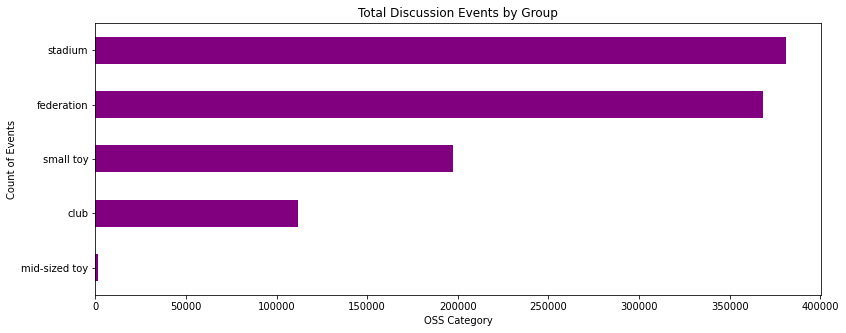

In [78]:
group_event_counts = community_group_stats.groupby("oss_category")["num_discussions_events"].sum()

group_event_counts.sort_values(inplace = True)

print(group_event_counts)
 
ax = group_event_counts.plot( kind="barh", color="purple", figsize=(13,5), title="Total Discussion Events by Group")
ax.set_xlabel("OSS Category")
ax.set_ylabel("Count of Events")